# Creating synthetic data: 
## sc cells, advecting on mean flow, modulated by waves
### later: advected also by wave divergent winds

from chatGPT: We can break it down into smaller components: generating cloud cells, simulating their growth and decay, applying a mean wind drift, and adding a gentle wave-like field for modulation. Please note that this will be a simplified representation and not a physically accurate simulation. We'll use Python and some common libraries for this task.


## Units: km and hours 

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# Constants
grid_size_x_km = 1000  # Width of the domain in kilometers
grid_size_y_km = 1000  # Height of the domain in kilometers
grid_resolution = 2    # Grid resolution in kilometers
time_steps = 48        # Number of time steps (every half-hour for a day)
time_resolution = 0.5  # in hours
cloud_growth_time = 8  # Time in steps for cloud growth, same for decay
wave_wavelength = 200  # Wavelength of the gentle waves in kilometers
wave_speed = 40        # km/hour

mean_wind_speed = 30  # Mean wind speed in km/h
mean_wind_direction = 300/360. *(2*np.pi)  # 300 = TOWARD 300deg


num_cells = 6000       # Adjust the number of cloud cells as desired
max_size = 3            # pixel size of cloud cells, then they are smoothed
smoothing_size=2       # for gaussian filter smoother

# Create a grid
grid_size_x = int(grid_size_x_km / grid_resolution)
grid_size_y = int(grid_size_y_km / grid_resolution)
grid = np.zeros((grid_size_x, grid_size_y, time_steps))

# Next, we'll generate cloud cells with random positions, sizes, and ages. 
# Each cell will slowly grow and decay over time:

# Generate random cloud cells initially
cloud_cells = []
for _ in range(num_cells):
    x = np.random.randint(grid_size_x)
    y = np.random.randint(grid_size_y)
    size = np.random.randint(1, max_size)           # Size in grid cells 
    age = np.random.randint(cloud_growth_time * 2)  # random initial age 
    cloud_cells.append((x, y, size, age))

    
# Sum up the grid 
# all done in time step units 
# Simulate cloud growth and decay, updating the list of active clouds

for t in range(time_steps):
    #print('time step ',t)
    new_cloud_cells = []
    for cell in cloud_cells:
        x, y, size, age = cell
        #print('cell age ',age)
        if age < cloud_growth_time:
            # Growing phase
            grid[x-size:x+size, y-size:y+size, t] = age
            # age the cloud cell by 1
            age += 1
            #print('young cell aged to ',x,y,age)
        elif age < 2 * cloud_growth_time:
            # Decaying phase
            grid[x-size:x+size, y-size:y+size, t] = 2*cloud_growth_time -age
            # age the cloud cell by 1
            age += 1
            #print('old cell aged to ',x,y,age)
        if age >= 2 * cloud_growth_time: 
            # dead cell: remove it, and generate a new one age 0
            cloud_cells.remove(cell)
            #print('DEAD! # remaining cells: ',len(cloud_cells))
            x = np.random.randint(grid_size_x)
            y = np.random.randint(grid_size_y)
            size = np.random.randint(1, max_size)  # Size in grid cells 
            age = 0  
            cloud_cells.append((x, y, size, age))
            #print("dead at age ", age, "replaced with ",x, y, size, age)
            #print('# is back to: ',len(cloud_cells))
        #print('cell age ',x,age)    
        
        cell = x, y, size, age # zip it back up in the list
        new_cloud_cells.append(cell)

    # replace the old cells with the new aged ones 
    cloud_cells = new_cloud_cells.copy()
    new_cloud_cells.clear()
# Smoothing    
    grid[:,:,t] = sp.ndimage.gaussian_filter(grid[:,:,t].copy(), smoothing_size, mode='wrap')
    
    
# Now, with all grids computed, let's add a mean wind drift to the cloud pattern:

# Calculate the wind drift, converted to grid cells per time step
grid_drift_x = mean_wind_speed * np.cos(mean_wind_direction) \
               /grid_resolution *time_resolution  # Convert km/hr to grid/step
grid_drift_y = mean_wind_speed * np.sin(mean_wind_direction) \
               /grid_resolution *time_resolution  # Convert km/hr to grid/step

# Apply wind drift to the cloud pattern
for t in range(1, time_steps):
    grid[:, :, t] = np.roll(grid[:, :, t], int(grid_drift_x * t), axis=0)
    grid[:, :, t] = np.roll(grid[:, :, t], int(grid_drift_y * t), axis=1)

    
#Finally, let's multiply the gentle wave-like field for modulation:

# Generate wave coordinate mesh, in gridpoints, centers of cells +0.5 
x_wave = np.linspace(0, grid_size_x-1,grid_size_x)+0.5
y_wave = np.linspace(0, grid_size_y-1,grid_size_y)+0.5
x_wave, y_wave = np.meshgrid(x_wave, y_wave)

# Apply wave modulation to the cloud pattern: sin(kx-ft), f=speed(km/h)/wavelength(km)
for t in range(time_steps):
    wave_modulation = np.sin(x_wave*grid_resolution * (2 *np.pi / wave_wavelength) +\
                             y_wave*grid_resolution * (2 *np.pi / wave_wavelength) -\
                             t*time_resolution *wave_speed/wave_wavelength * (2 *np.pi) )
                      #np.sin(t * (2 * np.pi) * wave_speed) 
    grid[:, :, t] *= (1 + 0.5*wave_modulation)

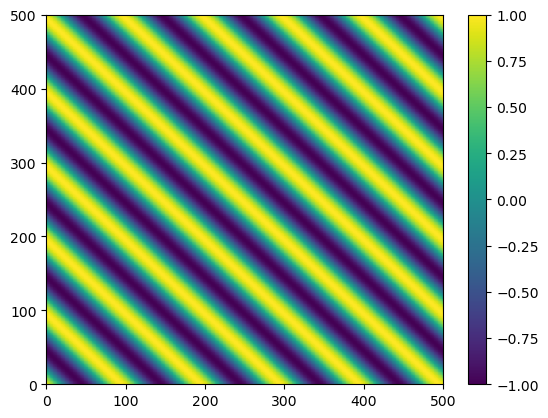

In [60]:
plt.pcolormesh(wave_modulation); plt.colorbar()

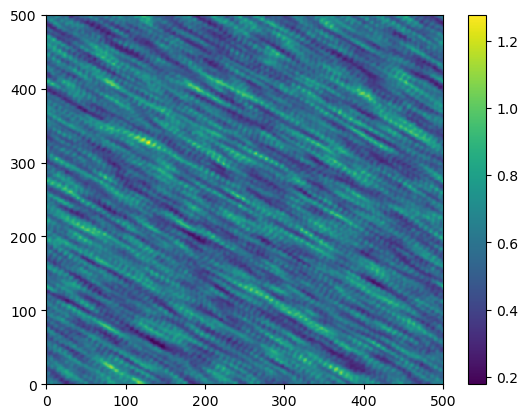

In [61]:
plt.pcolormesh(grid.mean(axis=2)); plt.colorbar()

In [62]:
grid.max()

8.597184212401618

In [63]:
2*cloud_growth_time/2

8.0

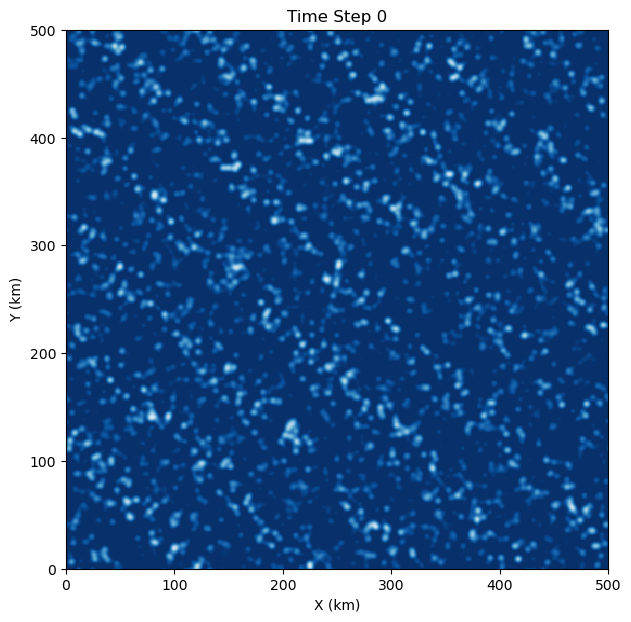

In [70]:
grid = grid.max()-grid # invert values! for blue color scale

from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(7, 7))  

# Function to initialize the animation at frame 10 
def init():
    im = ax.pcolormesh(grid[:, :, 0],vmin=0,vmax=2*cloud_growth_time/2,cmap='Blues')
    plt.title(f'Time Step 0')
    plt.xlabel('X (km)')
    plt.ylabel('Y (km)')
    return [im]

# Function to animate the frames
def animate(t):
    im = ax.pcolormesh(grid[:, :, t],vmin=0,vmax=2*cloud_growth_time/2,cmap='Blues')
    plt.title(f'Time Step {t}')
    return [im]

# Create an animation
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=22, repeat=True)

# Display the animation in the Jupyter Notebook
HTML(ani.to_jshtml())


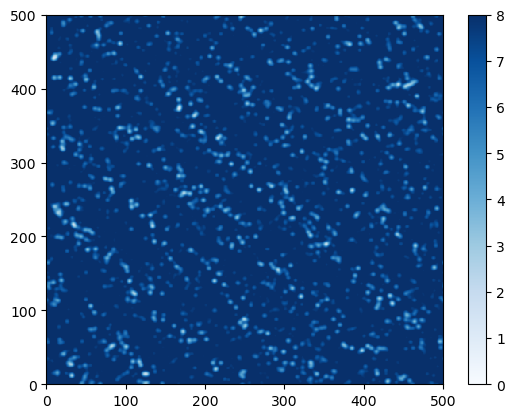

In [72]:
plt.pcolormesh(grid[:, :, 22],vmin=0,vmax=2*cloud_growth_time/2,cmap='Blues'); plt.colorbar()

In [ ]:
ani.save('stratocu_waves/DATA/synthetic_scwaves.mp4',writer='ffmpeg', fps=5)